In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import sys
sys.path.append("../scripts/")
from clean_data import DataCleaner
from utils import Utils
from HypothesisPlot import HypothesisPlot 
from DistributionPlots import DistributionPlots 

import warnings
warnings.filterwarnings('ignore')

In [2]:
cleaner = DataCleaner()
util=Utils()
dp=DistributionPlots()
hp=HypothesisPlot()


In [3]:
df = util.load_data('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


### Classical A/B Testing

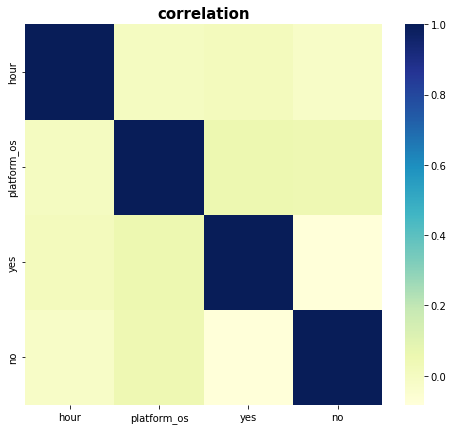

In [4]:
# Correlation Analysis

plt.figure(figsize=(8, 7))
corr = df.corr()
sns.heatmap(corr,cmap="YlGnBu")
plt.title('correlation', fontsize=15, fontweight='bold')
plt.show()